### Step a-b: create the base model
Questions: You want to implement a masking intervention in a simple compartmental model and simulate epidemic trajectories under different compliance scenarios. You found an existing model that incorporates masking as a time-dependent modification to the β parameter (https://doi.org/10.3390/ijerph18179027 plus accompanying code), and you want to ensure that the model is working as expected by reproducing plots in the publication. 

Replicate an analysis from the paper.
- (TA1 Model Extraction Workflow, TA2 Model Representation) Extract the SEIRD model (equations 1-5, with time-varying β as defined in equations 8-9) and load into the workbench. In equation 8, let kappa = γR0, R0 = 5. In equation 9, let k = 5.

- (TA3 Simulation Workflow, Unit Test): Replicate Figure 3 from the paper, which maps to the first scenario in the paper- implementing a masking intervention at several different timepoints (delays of 0 days, 50 days, 100 days, and control case, from the date of first infection) in the pandemic, with 100% compliance. Recreate the Fig. 3 curves (including peak infection times and levels), up to some reasonable margin of error.  

In [1]:
import sympy
from mira.metamodel import *
from mira.modeling import Model
from mira.modeling.askenet.petrinet import AskeNetPetriNetModel
from mira.modeling.viz import GraphicalModel

In [2]:
person_units = lambda: Unit(expression=sympy.Symbol('person'))
day_units = lambda: Unit(expression=sympy.Symbol('day'))
per_day_units = lambda: Unit(expression=1/sympy.Symbol('day'))
dimensionless_units = lambda: Unit(expression=sympy.Integer('1'))
per_day_per_person_units = lambda: Unit(expression=1/(sympy.Symbol('day')*sympy.Symbol('person')))

c = {
    'S': Concept(name='S', units=person_units(), identifiers={'ido': '0000514'}),
    'E': Concept(name='E', units=person_units(), identifiers={'apollosv': '0000154'}),
    'I': Concept(name='I', units=person_units(), identifiers={'ido': '0000511'}),
    'R': Concept(name='R', units=person_units(), identifiers={'ido': '0000592'}),
    'D': Concept(name='D', units=person_units(), identifiers={'ncit': 'C28554'}),
}


parameters = {
    'gamma': Parameter(name='gamma', value=1/11, units=per_day_units()),
    'delta': Parameter(name='delta', value=1/5, units=per_day_units()),
    'alpha': Parameter(name='alpha', value=0.000064, units=dimensionless_units()),
    'rho': Parameter(name='rho', value=1/9, units=per_day_units()),
    'N': Parameter(name='N', value=5_600_000, units=person_units()),
    'beta_s': Parameter(name='beta_s', value=1, units=per_day_units()),
    'beta_c': Parameter(name='beta_c', value=0.4, units=per_day_units()),
    't_0': Parameter(name='t_0', value=89, unts=day_units, units=day_units()),
    # D=11, gamma = 1/D, R_0 = 5 and
    # beta = R_0 * gamma * mask(t) so kappa = 5/11
    'kappa': Parameter(name='kappa', value=5/11, units=per_day_units()),
    'k': Parameter(name='k', value=5.0, units=dimensionless_units()),
}

initials = {
    'S': Initial(concept=Concept(name='S'), value=5_600_000-1),
    'E': Initial(concept=Concept(name='E'), value=1),
    'I': Initial(concept=Concept(name='I'), value=0),
    'R': Initial(concept=Concept(name='R'), value=0),
    'D': Initial(concept=Concept(name='D'), value=0),
}

In [3]:
S, E, I, R, D, N, kappa, beta_s, beta_c, k, t_0, t, alpha, delta, rho, gamma = \
    sympy.symbols('S E I R D N kappa beta_s beta_c k t_0 t alpha delta rho gamma')

In [4]:
m_1 = (beta_s - beta_c) / (1 + sympy.exp(-k*(t_0-t))) + beta_c
beta = kappa*m_1

t1 = ControlledConversion(subject=c['S'],
                          outcome=c['E'],
                          controller=c['I'],
                          rate_law=S*I*beta / N)
t2 = NaturalConversion(subject=c['E'],
                       outcome=c['I'],
                       rate_law=delta*E)
t3 = NaturalConversion(subject=c['I'],
                       outcome=c['R'],
                       rate_law=(1-alpha)*gamma*I)
t4 = NaturalConversion(subject=c['I'],
                       outcome=c['D'],
                       rate_law=alpha*rho*I)
templates = [t1, t2, t3, t4]
tm = TemplateModel(
    templates=templates,
    parameters=parameters,
    initials=initials,
    time=Time(name='t', units=day_units()),
    annotations=Annotations(name='Scenario 1a')
)
AskeNetPetriNetModel(Model(tm)).to_json_file('scenario1_a.json')

### Step c: update beta

(TA2 Model Modification Workflow, TA3 Simulation Workflow): Update the β(t) function to be defined as equations 8 and 10, with k1 = 5, and k2 = 1. This reflects the paper’s second scenario, gradual noncompliance with the masking policy over time. Rerun the simulation with several different delays in enforcing a mask policy (ranging from 0 to 140 days), and replicate Fig. 5, up to some reasonable margin of error.

In [5]:
k_1, k_2, t_1, beta_nc = sympy.symbols('k_1 k_2 t_1 beta_nc')
parameters['k_1'] = Parameter(name='k_1', value=5.0, units=dimensionless_units())
parameters['k_2'] = Parameter(name='k_2', value=1.0, units=dimensionless_units())
parameters['t_1'] = Parameter(name='t_1', value=154, units=day_units())
parameters['beta_nc'] = Parameter(name='beta_nc', value=0.5, units=per_day_units())
tm.parameters = parameters
tm.annotations = Annotations(name='Scenario 1c')
m_2 = (beta_s - beta_c) / (1 + sympy.exp(-k_1*(t_0-t))) + (beta_c - beta_nc) / (1 + sympy.exp(-k_2*(t_1-t))) + beta_nc

In [6]:
t1.rate_law = SympyExprStr(S*I*kappa*m_2/N)

In [7]:
t1.rate_law.args[0]

I*S*kappa*(beta_nc + (beta_c - beta_nc)/(1 + exp(-k_2*(-t + t_1))) + (-beta_c + beta_s)/(1 + exp(-k_1*(-t + t_0))))/N

In [8]:
AskeNetPetriNetModel(Model(tm)).to_json_file('scenario1_c.json')

### Step d: update for reinfection
(TA2 Model Modification Workflow, TA3 Simulation Workflow): Update the system of equations to include equations 6 and 7. This adds the potential for reinfection. Compare with the outcomes from 1c. What impact does immunity loss and potential for reinfection have?

In [9]:
epsilon = sympy.Symbol('epsilon')
parameters['epsilon'] = Parameter(name='epsilon', value=1/90, units=per_day_units())
tm.parameters = parameters
tm.annotations = Annotations(name='Scenario 1d')
t5 = NaturalConversion(subject=c['R'],
                       outcome=c['S'],
                       rate_law=epsilon*R)

In [10]:
AskeNetPetriNetModel(Model(tm)).to_json_file('scenario1_d.json')

## Demo unit normalization

In [11]:
tm_norm = counts_to_dimensionless(tm, 'person', 5_600_000)

In [12]:
tm_norm.initials

{'S': Initial(concept=Concept(name='S', display_name=None, description=None, identifiers={}, context={}, units=None), value=0.999999821428571),
 'E': Initial(concept=Concept(name='E', display_name=None, description=None, identifiers={}, context={}, units=None), value=1.78571428571429e-7),
 'I': Initial(concept=Concept(name='I', display_name=None, description=None, identifiers={}, context={}, units=None), value=0),
 'R': Initial(concept=Concept(name='R', display_name=None, description=None, identifiers={}, context={}, units=None), value=0),
 'D': Initial(concept=Concept(name='D', display_name=None, description=None, identifiers={}, context={}, units=None), value=0)}

In [13]:
tm_norm.parameters

{'gamma': Parameter(name='gamma', display_name=None, description=None, identifiers={}, context={}, units=Unit(expression=1/day), value=0.09090909090909091, distribution=None),
 'delta': Parameter(name='delta', display_name=None, description=None, identifiers={}, context={}, units=Unit(expression=1/day), value=0.2, distribution=None),
 'alpha': Parameter(name='alpha', display_name=None, description=None, identifiers={}, context={}, units=Unit(expression=1), value=6.4e-05, distribution=None),
 'rho': Parameter(name='rho', display_name=None, description=None, identifiers={}, context={}, units=Unit(expression=1/day), value=0.1111111111111111, distribution=None),
 'N': Parameter(name='N', display_name=None, description=None, identifiers={}, context={}, units=Unit(expression=1), value=1.0, distribution=None),
 'beta_s': Parameter(name='beta_s', display_name=None, description=None, identifiers={}, context={}, units=Unit(expression=1/day), value=1.0, distribution=None),
 'beta_c': Parameter(na

In [14]:
tm_norm.templates

[ControlledConversion(rate_law=I*S*kappa*(beta_nc + (beta_c - beta_nc)/(1 + exp(-k_2*(-t + t_1))) + (-beta_c + beta_s)/(1 + exp(-k_1*(-t + t_0))))/N, type='ControlledConversion', controller=Concept(name='I', display_name=None, description=None, identifiers={'ido': '0000511'}, context={}, units=Unit(expression=1)), subject=Concept(name='S', display_name=None, description=None, identifiers={'ido': '0000514'}, context={}, units=Unit(expression=1)), outcome=Concept(name='E', display_name=None, description=None, identifiers={'apollosv': '0000154'}, context={}, units=Unit(expression=1)), provenance=[]),
 NaturalConversion(rate_law=E*delta, type='NaturalConversion', subject=Concept(name='E', display_name=None, description=None, identifiers={'apollosv': '0000154'}, context={}, units=Unit(expression=1)), outcome=Concept(name='I', display_name=None, description=None, identifiers={'ido': '0000511'}, context={}, units=Unit(expression=1)), provenance=[]),
 NaturalConversion(rate_law=I*gamma*(1 - al

In [15]:
AskeNetPetriNetModel(Model(tm_norm)).to_json_file('scenario1_d_normalized.json')

## Part 2 c
c)	(TA2 Model Modification Workflow) Extend the core model extracted in Problem 1 of this scenario, by adding age stratification, new compartments (e.g., representing diagnosed/undiagnosed individuals), and vaccination, while maintaining the time-varying transmission aspects of the original model. Ensure that the functionality to extend an extracted model is available in the workbench.

In [16]:
tm_age = stratify(tm_norm,
                  key='age',
                  strata=['young', 'middle_aged', 'old'],
                  structure=[],
                  cartesian_control=True,
                  params_to_stratify={'kappa'})

set()


In [17]:
tm_age.parameters

{'gamma': Parameter(name='gamma', display_name=None, description=None, identifiers={}, context={}, units=Unit(expression=1/day), value=0.09090909090909091, distribution=None),
 'delta': Parameter(name='delta', display_name=None, description=None, identifiers={}, context={}, units=Unit(expression=1/day), value=0.2, distribution=None),
 'alpha': Parameter(name='alpha', display_name=None, description=None, identifiers={}, context={}, units=Unit(expression=1), value=6.4e-05, distribution=None),
 'rho': Parameter(name='rho', display_name=None, description=None, identifiers={}, context={}, units=Unit(expression=1/day), value=0.1111111111111111, distribution=None),
 'N': Parameter(name='N', display_name=None, description=None, identifiers={}, context={}, units=Unit(expression=1), value=1.0, distribution=None),
 'beta_s': Parameter(name='beta_s', display_name=None, description=None, identifiers={}, context={}, units=Unit(expression=1/day), value=1.0, distribution=None),
 'beta_c': Parameter(na

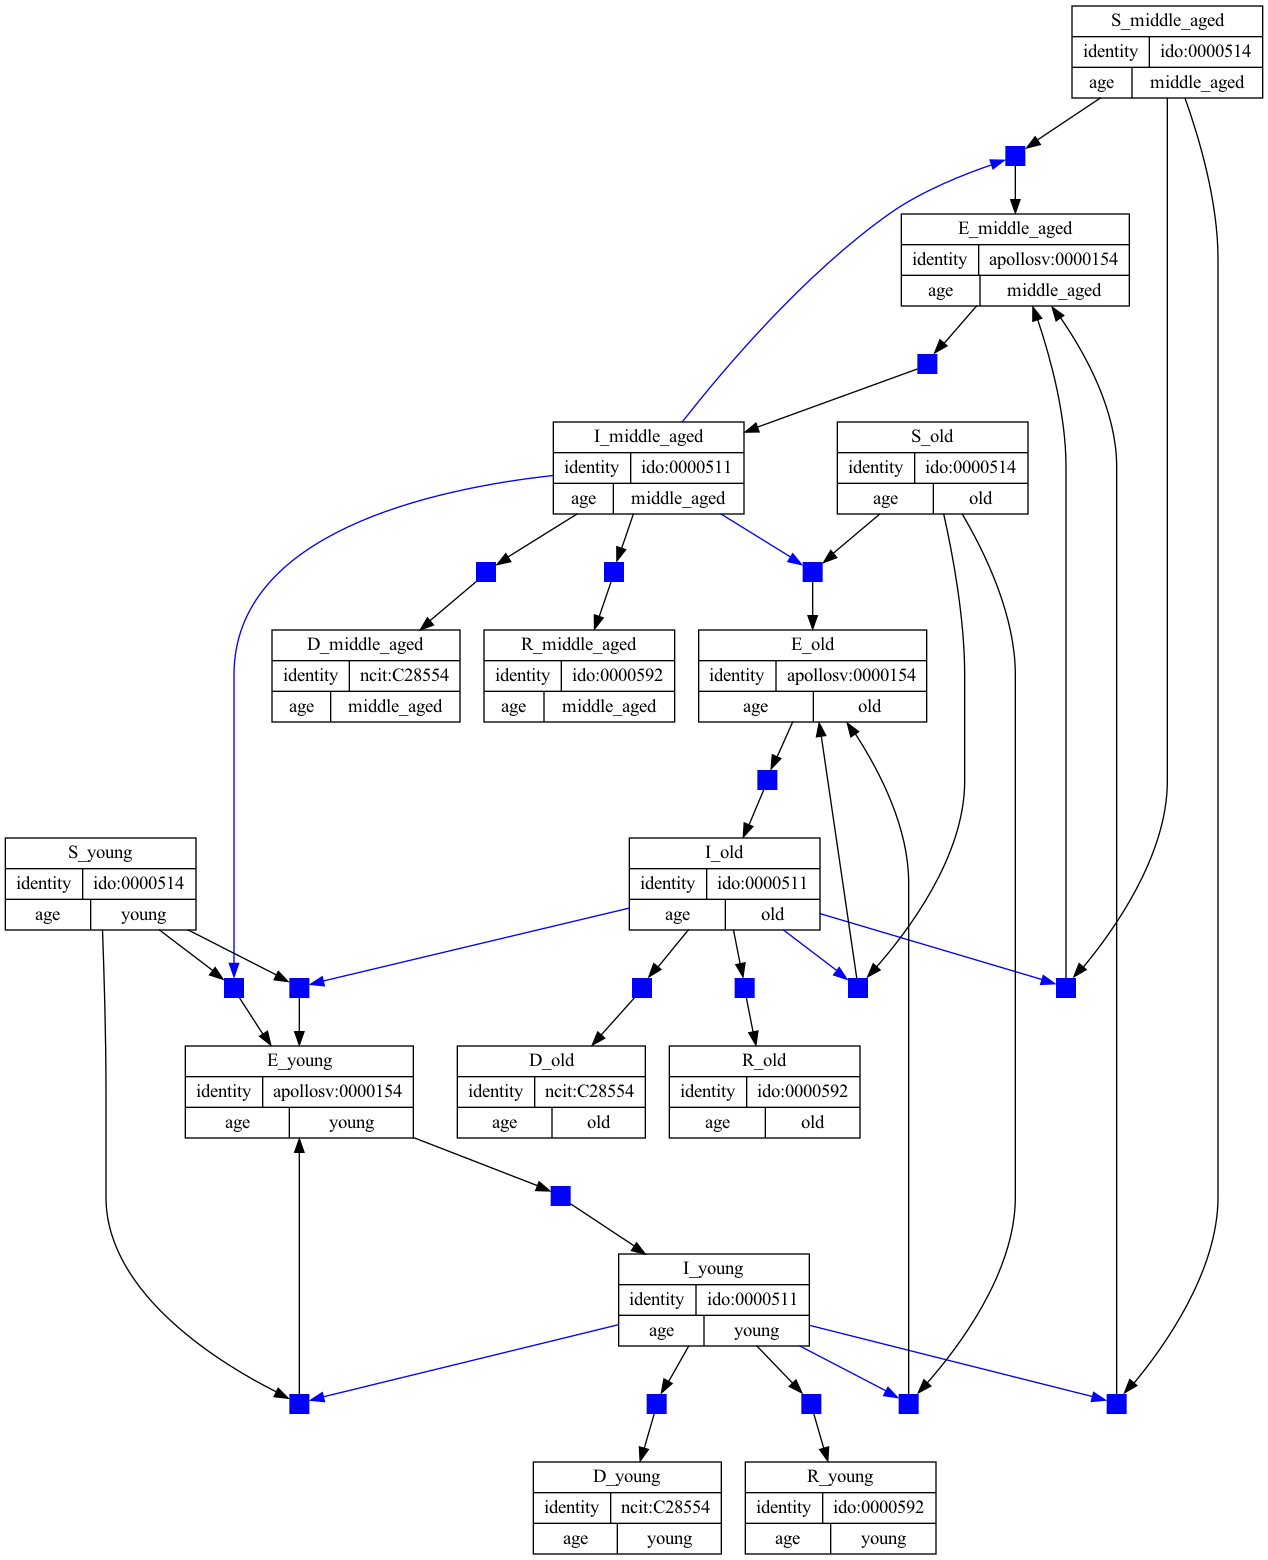

In [18]:
GraphicalModel.for_jupyter(tm_age)

In [19]:
tm_diag = stratify(tm_age,
                   key='diagnosis',
                   strata=['undiagnosed', 'diagnosed'],
                   structure=[['undiagnosed', 'diagnosed']],
                   directed=True,
                   concepts_to_stratify={'I_young', 'I_middle_aged', 'I_old'},
                   params_to_stratify={('kappa_%d' % i) for i in range(9)},
                   cartesian_control=True)

{'S_old', 'E_old', 'S_middle_aged', 'S_young', 'E_young', 'R_old', 'R_middle_aged', 'R_young', 'D_middle_aged', 'E_middle_aged', 'D_young', 'D_old'}


In [20]:
tm_diag.parameters

{'gamma': Parameter(name='gamma', display_name=None, description=None, identifiers={}, context={}, units=Unit(expression=1/day), value=0.09090909090909091, distribution=None),
 'delta': Parameter(name='delta', display_name=None, description=None, identifiers={}, context={}, units=Unit(expression=1/day), value=0.2, distribution=None),
 'alpha': Parameter(name='alpha', display_name=None, description=None, identifiers={}, context={}, units=Unit(expression=1), value=6.4e-05, distribution=None),
 'rho': Parameter(name='rho', display_name=None, description=None, identifiers={}, context={}, units=Unit(expression=1/day), value=0.1111111111111111, distribution=None),
 'N': Parameter(name='N', display_name=None, description=None, identifiers={}, context={}, units=Unit(expression=1), value=1.0, distribution=None),
 'beta_s': Parameter(name='beta_s', display_name=None, description=None, identifiers={}, context={}, units=Unit(expression=1/day), value=1.0, distribution=None),
 'beta_c': Parameter(na

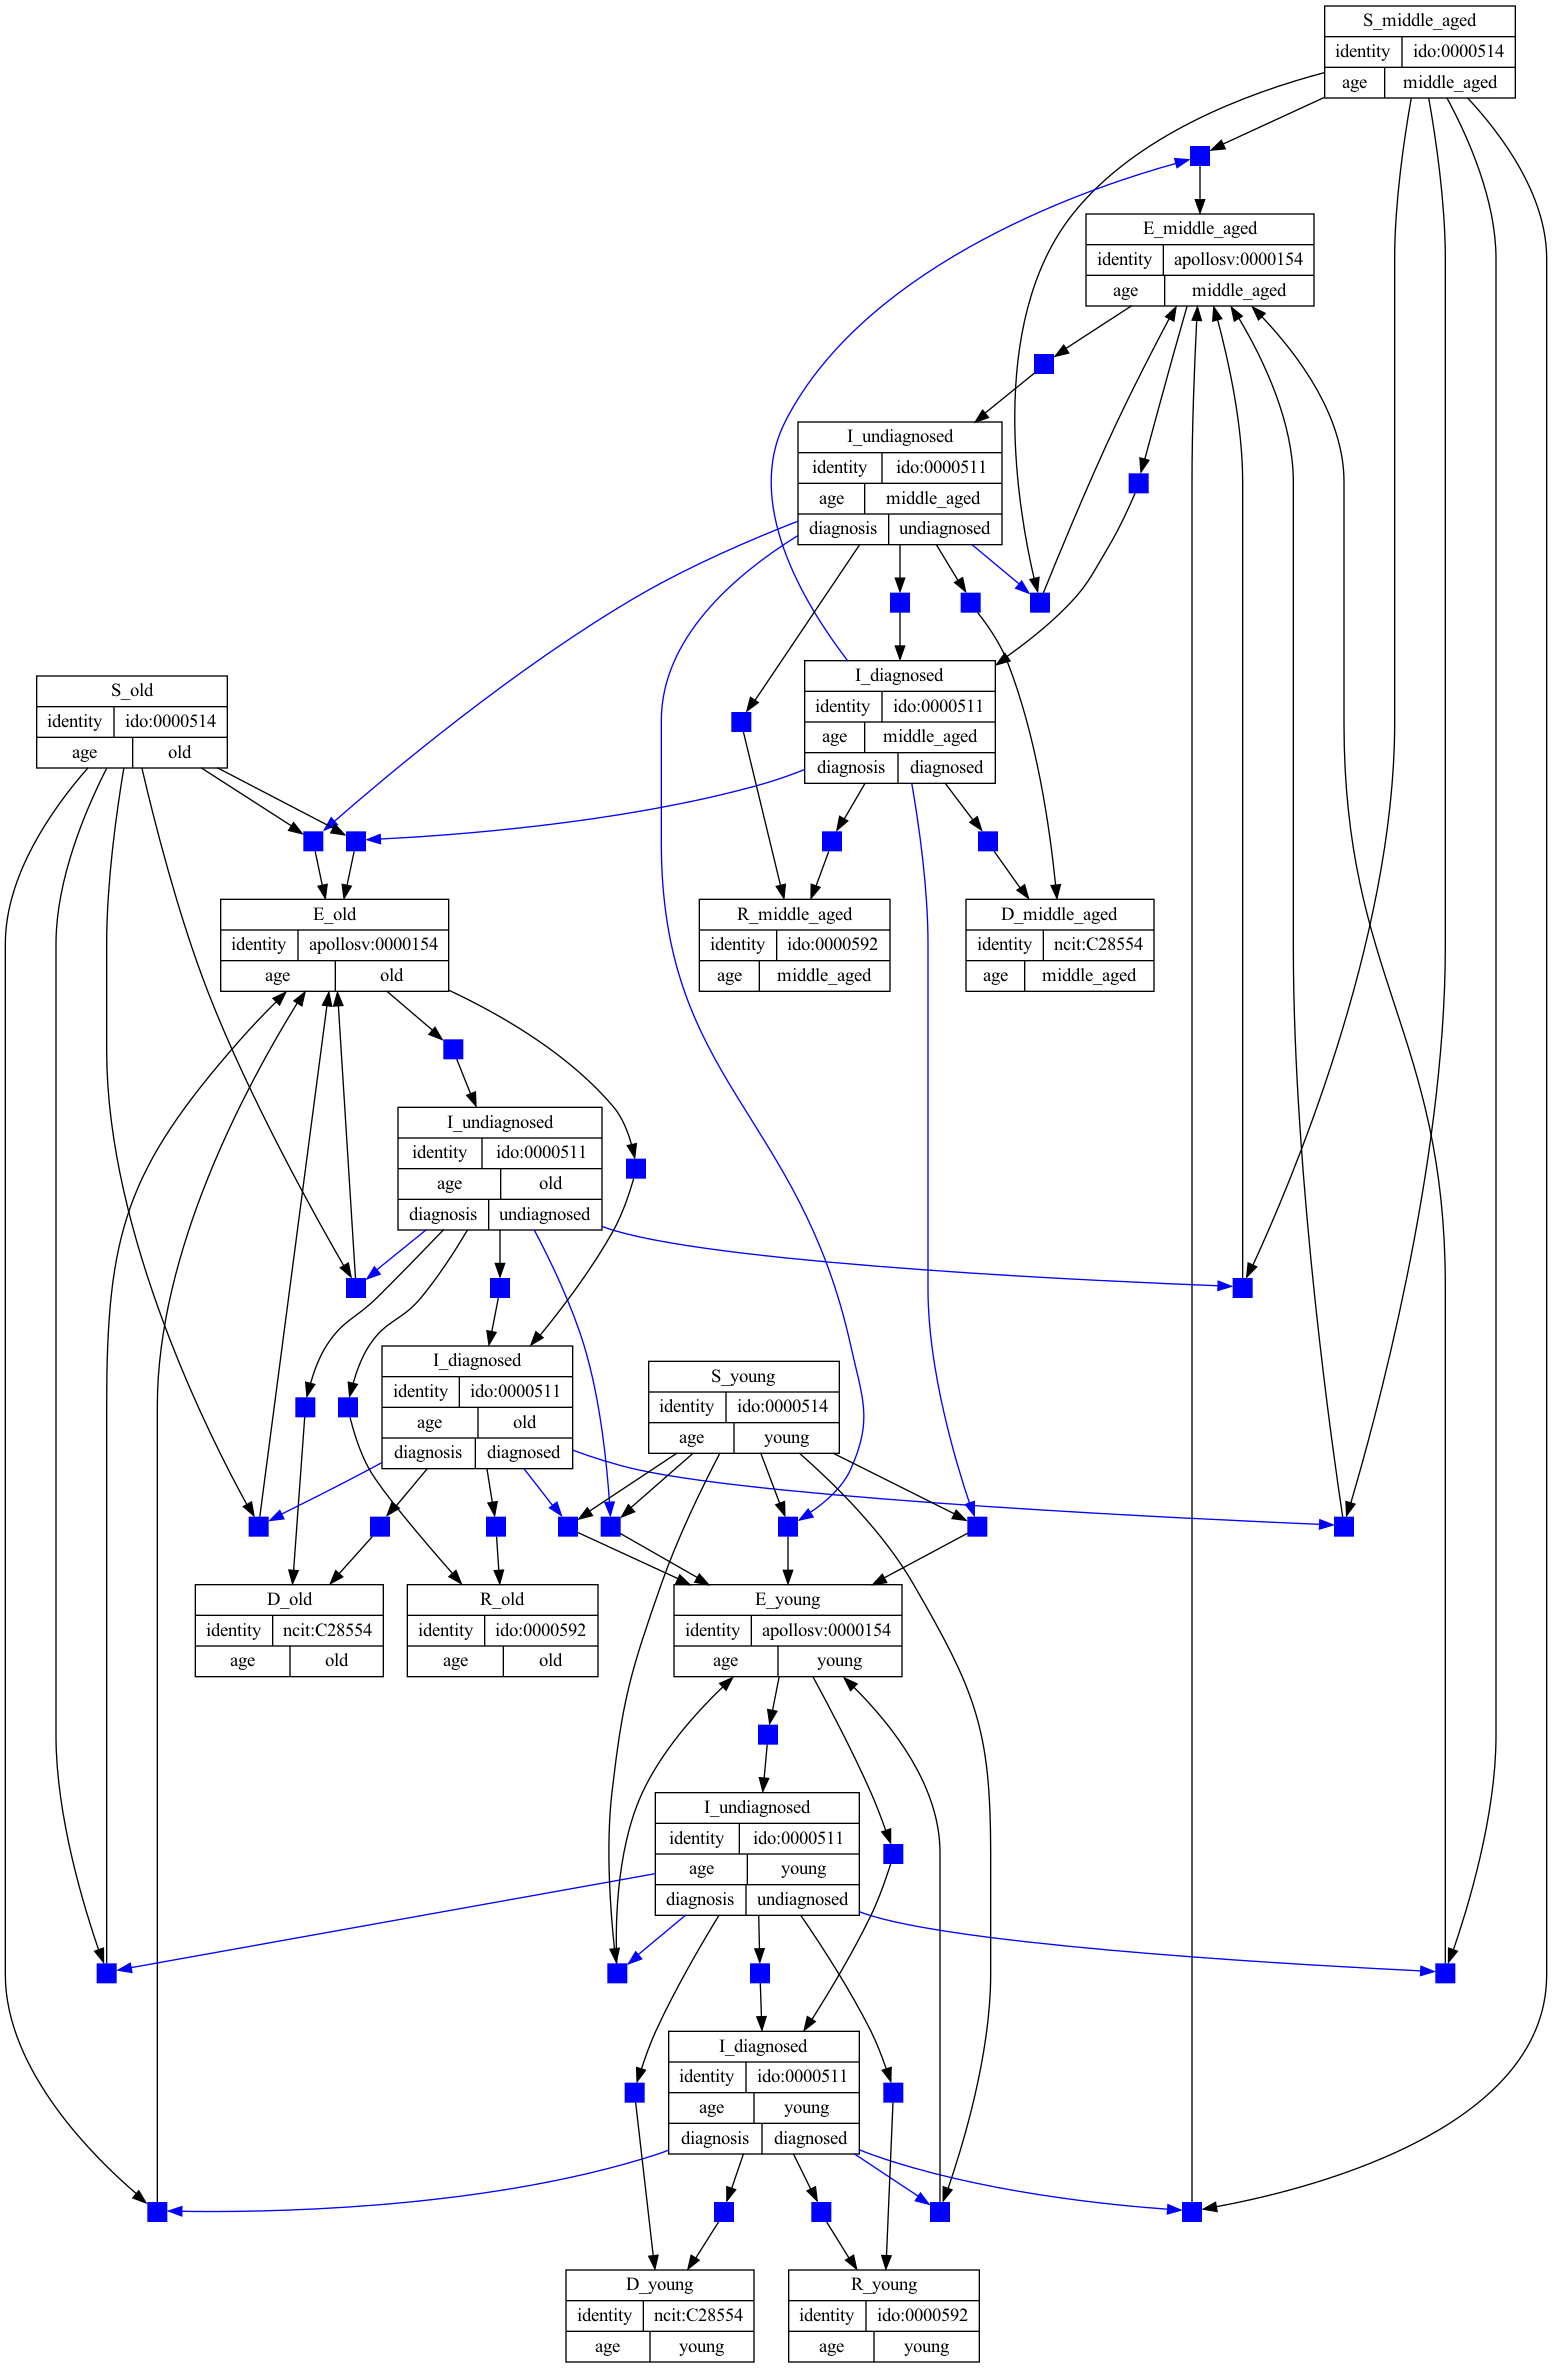

In [21]:
GraphicalModel.for_jupyter(tm_diag)

In [22]:
tm_vax = stratify(tm_age,
                  key='vax',
                  strata=['u', 'v'],
                  structure=[['u', 'v']],
                  directed=True,
                  cartesian_control=True,
                  concepts_to_preserve={'D_young', 'D_middle_aged', 'D_old')

SyntaxError: closing parenthesis ')' does not match opening parenthesis '{' (1990038434.py, line 7)

In [ ]:
GraphicalModel.for_jupyter(tm_age)

In [ ]:
tm.get_concepts_map()